# Train a scoring model

In this project, you will put yourself in the shoes of a data scientist working in a banking organisation. You work for the credit risk unit, and they ask you to use their data to provide them with a reliable model for detecting credit defaults.

# import of packages

Complete with the packages you need.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC 

from sklearn import tree

from sklearn.svm import SVR

import graphviz


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

## Loading in the Colab environment

You will use data from a Kaggle competition. 

You will find the dataset and more information informations about it, with this [link](https://www.kaggle.com/c/home-credit-default-risk/overview).

So that you don't bother to download the data, I did it for you. 

I share the data with you from my google drive. 

Before starting please import the TP files via the link below:

https://drive.google.com/drive/folders/1zYotRg3l_m66JQRrGYi1VkuW0A0tfC4K?usp=sharing

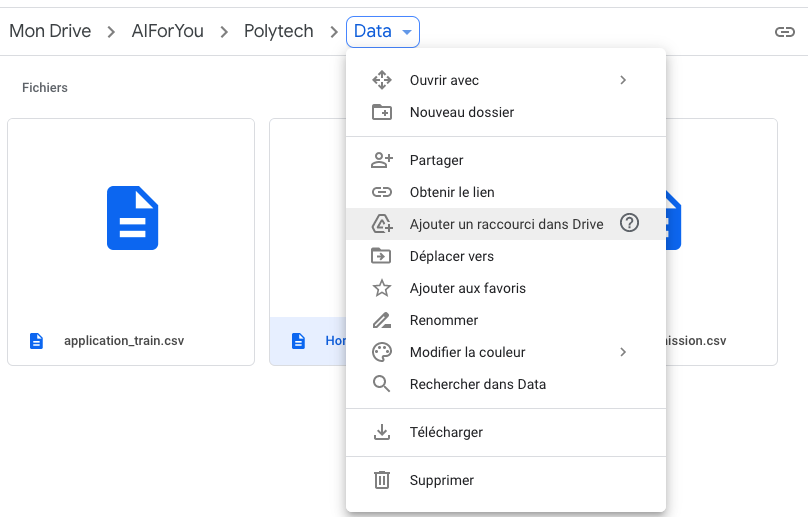

Add a shortcut to your drive.

In [56]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Data import 

Import of the data to be used during model training.

In [57]:
data = pd.read_csv('/content/gdrive/MyDrive/Data/application_train.csv')

Quick overview of the data.

In [58]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Data exploration

Explore your data to see what it's made of. Think about visualising and quantifying the interactions between your explanatory data and your target variable.

In [59]:
data.describe().round(0)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.0,307511.0,307511.0,307511.0,307511.0,307499.0,307233.0,307511.0,307511.0,307511.0,307511.0,307511.0,104582.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307509.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,134133.0,306851.0,246546.0,151450.0,127568.0,157504.0,103023.0,92646.0,143620.0,152683.0,154491.0,...,152683.0,154491.0,98869.0,124921.0,97312.0,153161.0,93997.0,137829.0,159080.0,306490.0,306490.0,306490.0,306490.0,307510.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,265992.0,265992.0,265992.0,265992.0,265992.0,265992.0
mean,278181.0,0.0,0.0,168798.0,599026.0,27109.0,538396.0,0.0,-16037.0,63815.0,-4986.0,-2994.0,12.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-963.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
std,102790.0,0.0,1.0,237123.0,402491.0,14494.0,369446.0,0.0,4364.0,141276.0,3523.0,1509.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,827.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
min,100002.0,0.0,0.0,25650.0,45000.0,1616.0,40500.0,0.0,-25229.0,-17912.0,-24672.0,-7197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4292.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,189146.0,0.0,0.0,112500.0,270000.0,16524.0,238500.0,0.0,-19682.0,-2760.0,-7480.0,-4299.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1570.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,278202.0,0.0,0.0,147150.0,513531.0,24903.0,450000.0,0.0,-15750.0,-1213.0,-4504.0,-3254.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-757.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Some observations:
- We have 307,511 observations.
- Our target value is a dummy, more than 75% of the dataset record a 0 at target value.
- Amt Income Total: presence of outlier (Max)
- Days_Employed: Very strange range with a positive value only for the max
- Own Car Age: lot of NA
- CNT FAM Members: presence of outlier (Max)
- EXT SOURCE 1: lot of NA
- Till the '...' the next variables are dummies, with a lot of NA


In [60]:
data.select_dtypes(include=['object']).describe().round(0)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


Some observations:
- Occupation type, Fondkapremont mode, housetype moden wallsmaterial mode et emergencystate mode have a lot of NA

We can convert this data into dummies to ease the analysis.

In [61]:
data = pd.get_dummies(data)

In [62]:
data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We will compute the correlation matrix to find the most relevant parameters.

In [63]:
corr_table = data.corr()

In [64]:
corr_table = corr_table.apply(abs)

In [65]:
corr_table_sort = corr_table[['TARGET']].sort_values(by='TARGET')

In [66]:
corr_table_sort

,TARGET
ORGANIZATION_TYPE_Industry: type 7,0.000094
ORGANIZATION_TYPE_Advertising,0.000117
FLAG_DOCUMENT_20,0.000215
ORGANIZATION_TYPE_Legal Services,0.000236
NAME_HOUSING_TYPE_Co-op apartment,0.000312
...,...
DAYS_BIRTH,0.078239
EXT_SOURCE_1,0.155317
EXT_SOURCE_2,0.160472
EXT_SOURCE_3,0.178919


# Data selection

Select from among the available variables those that seem most promising for the training of your model.

We will take the top 20 most correlated variables with the target value.

After, we will compute the correlation between this 20 variables to see if we can remove some of them.

In [67]:
corr_table_sort.tail(21)

,TARGET
FLAG_DOCUMENT_3,0.044346
REG_CITY_NOT_LIVE_CITY,0.044395
DAYS_EMPLOYED,0.044932
FLAG_EMP_PHONE,0.045982
ORGANIZATION_TYPE_XNA,0.045987
NAME_INCOME_TYPE_Pensioner,0.046209
NAME_EDUCATION_TYPE_Secondary / secondary special,0.049824
REG_CITY_NOT_WORK_CITY,0.050994
DAYS_ID_PUBLISH,0.051457
CODE_GENDER_F,0.054704


In [68]:
selection = data.loc[:,['FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_F', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

We can remove Days_employed because of the anomalies in the variable.

In [69]:
selection = data.loc[:,['FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_F', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

In [70]:
selection.corr().round(2)

,FLAG_DOCUMENT_3,REG_CITY_NOT_LIVE_CITY,FLAG_EMP_PHONE,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Pensioner,NAME_EDUCATION_TYPE_Secondary / secondary special,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,CODE_GENDER_F,CODE_GENDER_M,DAYS_LAST_PHONE_CHANGE,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
FLAG_DOCUMENT_3,1.00,0.00,0.25,-0.25,-0.25,0.06,0.06,0.05,0.09,-0.09,-0.06,-0.06,0.16,0.06,0.07,0.11,-0.04,-0.03,-0.03
REG_CITY_NOT_LIVE_CITY,0.00,1.00,0.09,-0.09,-0.09,-0.02,0.44,0.08,-0.05,0.05,0.05,0.01,0.03,0.04,0.05,0.18,-0.14,-0.04,-0.08
FLAG_EMP_PHONE,0.25,0.09,1.00,-1.00,-1.00,-0.11,0.26,0.27,-0.16,0.16,-0.02,0.10,0.48,-0.03,-0.03,0.62,-0.29,0.02,-0.12
ORGANIZATION_TYPE_XNA,-0.25,-0.09,-1.00,1.00,1.00,0.11,-0.26,-0.27,0.16,-0.16,0.02,-0.10,-0.48,0.03,0.03,-0.62,0.29,-0.02,0.12
NAME_INCOME_TYPE_Pensioner,-0.25,-0.09,-1.00,1.00,1.00,0.11,-0.26,-0.27,0.16,-0.16,0.02,-0.10,-0.48,0.03,0.03,-0.62,0.29,-0.02,0.12
NAME_EDUCATION_TYPE_Secondary / secondary special,0.06,-0.02,-0.11,0.11,0.11,1.00,0.02,-0.04,-0.00,0.00,-0.00,-0.89,0.07,0.07,0.07,-0.16,-0.10,-0.11,0.04
REG_CITY_NOT_WORK_CITY,0.06,0.44,0.26,-0.26,-0.26,0.02,1.00,0.10,-0.14,0.14,0.05,-0.02,0.15,0.01,0.03,0.24,-0.19,-0.08,-0.08
DAYS_ID_PUBLISH,0.05,0.08,0.27,-0.27,-0.27,-0.04,0.10,1.00,-0.00,0.00,0.09,0.03,0.13,-0.01,-0.01,0.27,-0.13,-0.05,-0.13
CODE_GENDER_F,0.09,-0.05,-0.16,0.16,0.16,-0.00,-0.14,-0.00,1.00,-1.00,-0.03,0.02,-0.11,0.02,0.02,-0.15,0.31,0.01,0.02
CODE_GENDER_M,-0.09,0.05,0.16,-0.16,-0.16,0.00,0.14,0.00,-1.00,1.00,0.03,-0.02,0.11,-0.02,-0.02,0.15,-0.31,-0.01,-0.02


We decided a threshold of 0.4 of correlation between variables to keep only one of the ones concerned:
- REG_CITY_NOT_LIVE_CITY and REG_CITY_NOT_WORK_CITY	
- FLAG_EMP_PHONE and ORGANIZATION_TYPE_XNA and NAME_INCOME_TYPE_Pensioner and NAME_INCOME_TYPE_Working and DAYS_BIRTH
- NAME_EDUCATION_TYPE_Secondary / secondary special	and NAME_EDUCATION_TYPE_Higher education
- CODE_GENDER_F and CODE_GENDER_M
- REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY
- DAYS_BIRTH and EXT_SOURCE_1

We keep the variables the most correlated with target: 
- REG_CITY_NOT_WORK_CITY
- NAME_EDUCATION_TYPE_Higher education
- CODE_GENDER_M
- REGION_RATING_CLIENT_W_CITY
- EXT_SOURCE_1

In [71]:
selection = data.loc[:,['FLAG_DOCUMENT_3', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

It remains 11 variables.

In [72]:
y = data.TARGET
X = selection

# Data Cleaning

Implement data cleaning to remove missing values.

We decided to replace missing value by the mean of the column. Some variables very correlated with the Target contain a lot of NA, such as EXT_SOURCE_1. We cannot delete them because they will be useful for predict the target.

In [73]:
X.mean()

FLAG_DOCUMENT_3                            0.710023
REG_CITY_NOT_WORK_CITY                     0.230454
DAYS_ID_PUBLISH                        -2994.202373
CODE_GENDER_M                              0.341643
DAYS_LAST_PHONE_CHANGE                  -962.858788
NAME_EDUCATION_TYPE_Higher education       0.243448
NAME_INCOME_TYPE_Working                   0.516320
REGION_RATING_CLIENT_W_CITY                2.031521
EXT_SOURCE_1                               0.502130
EXT_SOURCE_2                               0.514393
EXT_SOURCE_3                               0.510853
dtype: float64

In [74]:
X = X.apply(lambda x: x.fillna(x.mean()),axis=0)

In [75]:
X

,FLAG_DOCUMENT_3,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,CODE_GENDER_M,DAYS_LAST_PHONE_CHANGE,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,0,-2120,1,-1134.0,0,1,2,0.083037,0.262949,0.139376
1,1,0,-291,0,-828.0,1,0,1,0.311267,0.622246,0.510853
2,0,0,-2531,1,-815.0,0,1,2,0.502130,0.555912,0.729567
3,1,0,-2437,0,-617.0,0,1,2,0.502130,0.650442,0.510853
4,0,1,-3458,1,-1106.0,0,1,2,0.502130,0.322738,0.510853
...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,-1982,1,-273.0,0,1,1,0.145570,0.681632,0.510853
307507,1,0,-4090,0,0.0,0,0,2,0.502130,0.115992,0.510853
307508,1,1,-5150,0,-1909.0,1,1,3,0.744026,0.535722,0.218859
307509,1,1,-931,0,-322.0,0,0,2,0.502130,0.514163,0.661024


# Data spliting

Sequencing of data sets for model training.

If you need help, feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=123)

# Establish a baseline model

Create a very simple template (without machine learning) that will serve as a reference for the rest of the project.

Our baseline model is the random classifier.  

(-1.107699336213084,
 1.1026246213582482,
 -1.1075302665025313,
 1.100358584119168)

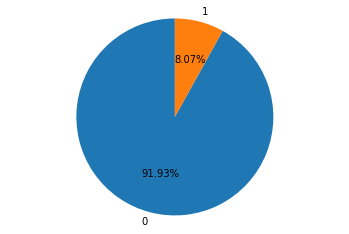

In [ ]:
target_val = data.loc[:, 'TARGET'].value_counts()
target_df = pd.DataFrame({'labels': target_val.index,
                   'values': target_val.values
                  })
fig1, ax1 = plt.subplots()
ax1.pie(target_val, labels=target_df.loc[:,"labels"], autopct='%1.2f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

A random classifier has a natural accuracy of 91.93%.  
To add value, our models must have a natural accuracy above 91.93%.

# Use Logistic regression algorithm to train a model 

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Data preprocessing

In [77]:
# Initialize the StandardScaler function
scaler = StandardScaler()

# Fit the StandardScaler on the trainig set
scaler.fit(X_train)

# Standardization of the training set
X_train_norm = scaler.transform(X_train)

# Standardization of the validation set
X_test_norm = scaler.transform(X_test)

# Model Initialization
reg = LogisticRegression()

### Train your model on the training dataset

In [78]:
# Model Training
reg.fit(X_train_norm, y_train)

LogisticRegression()

### Evaluate your model on the testing dataset

In [79]:
# Results
y_train_prediction = reg.predict(X_train_norm)

y_test_prediction = reg.predict(X_test_norm)

In [80]:
y_train_prediction_proba = reg.predict_proba(X_train_norm)[:, 1]

y_test_prediction_proba = reg.predict_proba(X_test_norm)[:, 1]

In [81]:
acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(4)*100) + '%.')

Accuracy: 91.94%.
Precision: 30.0%.
Recall: 0.32%.
F1-score: 0.64%.


The accuracy is slightly above the baseline model. But it is not satisfying. The adding value of the logistical model is only 0.01% of accuracy.  
The precision represents the proportion of True Positive on all predicted positive. Reduces the number of false positive increases the precision.  
The recall represents the proportion of True Positive on all real positive values. Reduces the number of false negative increases the recall.

Theses scores must be compared with other models to be well interpretad. However, the intuition is that the logistic model gives to much false negative.

**The aim of the project is to tackle the problem of people who cannot have a loan. So we want a good accuracy rate but also the highest recall ratio to stop miss theses opportunities.**


### Find the best set of hyperparameters

Feel free to find the best hyperparameters of the penalized logistic regression.

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
dict_of_hyperparametrs = {'dual' : [True, False], 
                          'max_iter': [100,110,120,130,140],
                          'C' : [1.0,1.5,2.0,2.5]}

default_predictions = reg.predict(X_test_norm)

In [ ]:
print(classification_report(y_test, default_predictions)) 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28285
           1       0.30      0.00      0.01      2467

    accuracy                           0.92     30752
   macro avg       0.61      0.50      0.48     30752
weighted avg       0.87      0.92      0.88     30752



In [ ]:
grid = GridSearchCV(reg.fit(X_train_norm, y_train), dict_of_hyperparametrs, verbose=3, scoring='recall') 

In [ ]:
grid.fit(X_train_norm, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......C=1.0, dual=True, max_iter=100;, score=nan total time=   0.0s
[CV 2/5] END ......C=1.0, dual=True, max_iter=100;, score=nan total time=   0.0s
[CV 3/5] END ......C=1.0, dual=True, max_iter=100;, score=nan total time=   0.0s
[CV 4/5] END ......C=1.0, dual=True, max_iter=100;, score=nan total time=   0.0s
[CV 5/5] END ......C=1.0, dual=True, max_iter=100;, score=nan total time=   0.0s
[CV 1/5] END ......C=1.0, dual=True, max_iter=110;, score=nan total time=   0.0s
[CV 2/5] END ......C=1.0, dual=True, max_iter=110;, score=nan total time=   0.0s
[CV 3/5] END ......C=1.0, dual=True, max_iter=110;, score=nan total time=   0.0s
[CV 4/5] END ......C=1.0, dual=True, max_iter=110;, score=nan total time=   0.0s
[CV 5/5] END ......C=1.0, dual=True, max_iter=110;, score=nan total time=   0.0s
[CV 1/5] END ......C=1.0, dual=True, max_iter=120;, score=nan total time=   0.0s
[CV 2/5] END ......C=1.0, dual=True, max_iter=1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 453, in _check_solver
    "Solver %s supports only dual=Fals

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1.0, 1.5, 2.0, 2.5], 'dual': [True, False],
                         'max_iter': [100, 110, 120, 130, 140]},
             scoring='recall', verbose=3)

In [ ]:
print(grid.best_params_) 

{'C': 1.0, 'dual': False, 'max_iter': 100}


Finally, the best logistical model to optimize the recall is the default one.


### Graphical representation of the result

You can use ROC curve

In [82]:
auc_log = roc_auc_score(y_test,y_test_prediction_proba)
print('ROC AUC score:', auc_log)

ROC AUC score: 0.7293463751572016


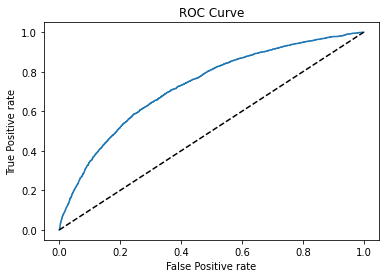

In [83]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_test_prediction_proba)
plt.plot(fpr1, tpr1)
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('ROC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()

### Interpret the coefficient

The coefficient and the model shows that the model is better than a random classifier because it is above the middle line and the coeff is above 0.5.  
The coeff has not a lot a sens alone, we must compare it with different models.

### Make a conclusion about this model to solve you scoring model

Logistical model has a lot of adding value compare with the baseline model. It gives a good reference but we espect that we can find better models.

We keep in mind theses figures :  
**Logistic Model**  
Accuracy: 91.94%.  
Precision: 30.0%.  
Recall: 0.32%.  
F1-score: 0.64%.  
ROC AUC score: 0.7073119821918012.

# Use decision tree algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

### Train your model on the training dataset

In [ ]:
# Model Initialization
decision_tree = DecisionTreeClassifier(random_state=123)

# Model Training
decision_tree.fit(X_train_norm, y_train)

DecisionTreeClassifier(random_state=123)

### Evaluate your model on the testing dataset

In [ ]:
# Results
y_train_prediction = decision_tree.predict(X_train_norm)

y_test_prediction = decision_tree.predict(X_test_norm)

y_train_prediction_proba = decision_tree.predict_proba(X_train_norm)[:, 1]

y_test_prediction_proba = decision_tree.predict_proba(X_test_norm)[:, 1]

In [ ]:
acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(4)*100) + '%.')

Accuracy: 85.17%.
Precision: 13.0%.
Recall: 15.2%.
F1-score: 14.12%.


The Accuracy is lower than the baseline model, so a simple decision tree has no adding value.  In the other hand, the recall is higher.  
I think it is really bad to have a accuracy below the baseline model, so we won't keep this model and prefer find an optimum with hyperparameters.

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# The tested parameters
dict_of_hyperparametrs = {'criterion' : ['gini', 'entropy'], 
                          'max_depth': [2, 3, 4, 5],
                          'min_samples_leaf' : [2, 3, 4, 5],
                          'min_samples_split' : [2, 3, 4, 5]}

default_predictions = decision_tree.predict(X_test_norm)

In [ ]:
grid = GridSearchCV(decision_tree.fit(X_train_norm, y_train), dict_of_hyperparametrs, verbose=3, scoring='recall') 

In [ ]:
grid.fit(X_train_norm, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.000 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.000 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.000 total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.000 total time=   0.4s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.000 total time=   0.4s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=3;, score=0.000 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=3;, score=0.000 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=3;, score=0.000 total time=   0.4s
[CV 4/5] END crit

GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='recall', verbose=3)

In [ ]:
# Result of the Gridsearch algorithm
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

The best hyperparameters to optimize the recall is {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [84]:
# Optimized Model Initialization
decision_tree_opt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, min_samples_split=2)

# Optimized Model Training
decision_tree_opt.fit(X_train_norm, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2)

In [85]:
# Results
y_train_prediction = decision_tree_opt.predict(X_train_norm)

y_test_prediction = decision_tree_opt.predict(X_test_norm)

y_train_prediction_proba = decision_tree_opt.predict_proba(X_train_norm)[:, 1]

y_test_prediction_proba = decision_tree_opt.predict_proba(X_test_norm)[:, 1]

In [86]:
acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(4)*100) + '%.')

Accuracy: 91.96%.
Precision: 45.0%.
Recall: 0.97%.
F1-score: 1.9%.


The Accuracy and the Recall are slighly above the Logistical model. There is also a good improve on the precision (this is not a targeted indicator but it is good anyway). We will prefer this model with the good hyperparameters.

### Graphical representation of the result

You can use ROC curve

In [87]:
auc_log = roc_auc_score(y_test,y_test_prediction_proba)
print('ROC AUC score:', auc_log)

ROC AUC score: 0.7073119821918012


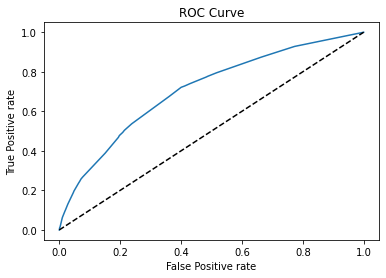

In [88]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_test_prediction_proba)
plt.plot(fpr2, tpr2)
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('ROC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()

The ROC is less good than in the logistic model.

### Visualize the tree

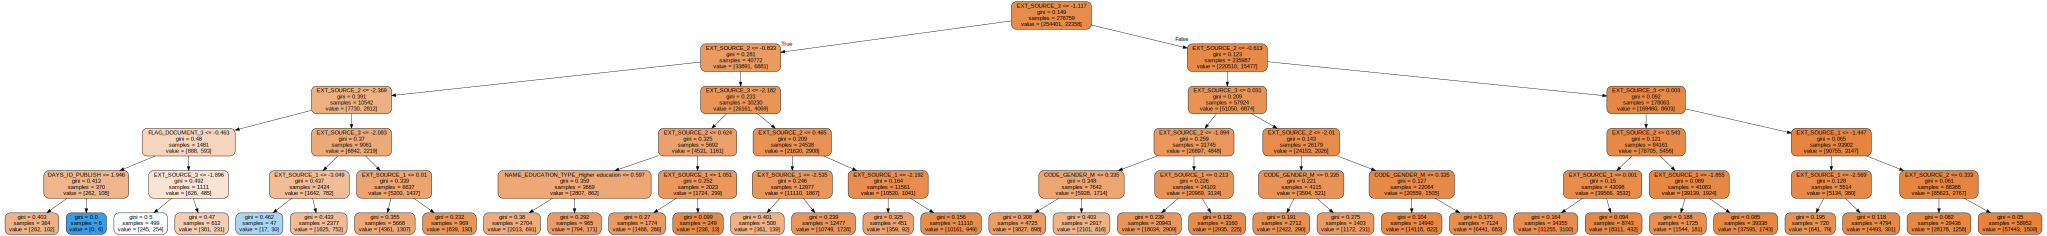

In [ ]:
dot_data = tree.export_graphviz(decision_tree_opt,
                                feature_names=['FLAG_DOCUMENT_3', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'],
                                filled=True,
                                rounded=True)  
graph = graphviz.Source(dot_data)
graph

The only way to have a gini >= 0.5 is:  
- EXT_SOURCE_3 <= -1.117
- EXT_SOURCE_2 <= -0.833
- EXT_SOURCE_2 <= -2.369
- FLAG_DOCUMENT_3 <= -0.463
- EXT_SOURCE_3 <= -1.896

### Make a conclusion about this model to solve you scoring model

The model is better on some indicators like accuracy, recall and precision. But the drop of the ROC AUC shows that it is not really good model.

We keep in mind theses figures :  
**Decision Tree**  
Accuracy: 91.96%.  
Precision: 45.0%.  
Recall: 0.97%.  
F1-score: 1.9%.  
ROC AUC score: 0.7073119821918012.

# Use the random forest algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

### Train your model on the training dataset

In [ ]:
# Model Initialization
rf = RandomForestClassifier(n_estimators = 100, random_state = 123)

# Model Training
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

### Evaluate your model on the testing dataset

In [ ]:
# Results
y_train_prediction = rf.predict(X_train)
y_test_prediction = rf.predict(X_test)

acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(4)*100) + '%.')

Accuracy: 91.86%.
Precision: 32.0%.
Recall: 1.26%.
F1-score: 2.42%.


Compared with the decision tree model, the Recall is better but the accuracy and the precision are below.  
Let's try to find the best hyperparameters.

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# The tested parameters
dict_of_hyperparametrs = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
                          'max_features': ['auto'],
                          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                          'min_samples_split': [2, 5, 10],
                          'min_samples_leaf': [1, 2, 4],
                          'bootstrap': [True]}

In [ ]:
grid = RandomizedSearchCV(RandomForestClassifier(random_state=123, verbose=1), dict_of_hyperparametrs, verbose=1, n_iter = 100, cv=2, scoring='recall') 

In [ ]:
# The computation was very long, I prefer to keep it as a comment.
'grid.fit(X_train_norm, y_train)'
'grid.best_params_'

Result of the Gridsearch algorithm   
We find: n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_depth=40.

In [89]:
# Optimized Model Initialization
rf_opt = RandomForestClassifier(n_estimators = 50, random_state = 123, min_samples_leaf=2, min_samples_split=5, max_depth=40, bootstrap=True, max_features='auto')

# Optimized Model Training
rf_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=123)

In [90]:
# Results
y_train_prediction = rf_opt.predict(X_train)
y_test_prediction = rf_opt.predict(X_test)

y_train_prediction_proba = rf_opt.predict_proba(X_train)[:, 1]
y_test_prediction_proba = rf_opt.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(2)*100) + '%.')

Accuracy: 91.91%.
Precision: 37.0%.
Recall: 1.13%.
F1-score: 2.0%.


We have the best recall ratio since the beginning. Even if the accuracy is slightly below the accuracy of the decision tree model, we prefer this model.

### Extract the feature importance of the model

In [ ]:
feature_importance_rf_opt = rf_opt.feature_importances_
feature_importances_rf_opt = pd.DataFrame({'feature': ['FLAG_DOCUMENT_3', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] ,
                                    'importance': feature_importance_rf_opt}).sort_values(by=['importance'], ascending=False)
feature_importances_rf_opt.head()

,feature,importance
9,EXT_SOURCE_2,0.240833
2,DAYS_ID_PUBLISH,0.204093
10,EXT_SOURCE_3,0.186858
4,DAYS_LAST_PHONE_CHANGE,0.180206
8,EXT_SOURCE_1,0.107889


We are not surprised to find the 3 EXT_SOURCE because they are the most correlated variables with the Target value. The others are a bit more unexpected. 

### Graphical representation of the result

You can use ROC curve

In [91]:
auc_log = roc_auc_score(y_test,y_test_prediction_proba)
print('ROC AUC score:', auc_log)

ROC AUC score: 0.7017782331513471


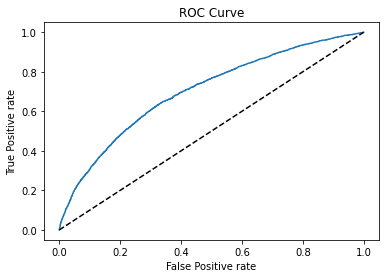

In [92]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_test_prediction_proba)
plt.plot(fpr3, tpr3)
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('ROC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()

### Make a conclusion about this model to solve you scoring model

The model has the smaller ROC AUC score but it is good in term of recall and accuracy. We can prefer this model compares to the others.  
We keep in mind theses figures :  
**Random Forest**  
Accuracy: 91.91%.  
Precision: 37.0%.  
Recall: 1.13%.  
F1-score: 2.0%.  
ROC AUC score: 0.7017782331513471

# Use AdaBoost algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

### Train your model on the training dataset

In [93]:
# Model Initialization
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2), n_estimators = 100, random_state = 42)

### Evaluate your model on the testing dataset

In [94]:
# Model Training
ada.fit(X_train, y_train)

# Results
y_train_prediction = ada.predict(X_train)
y_test_prediction = ada.predict(X_test)

y_train_prediction_proba = ada.predict_proba(X_train)[:, 1]
y_test_prediction_proba = ada.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(2)*100) + '%.')

Accuracy: 91.96%.
Precision: 47.0%.
Recall: 1.46%.
F1-score: 3.0%.


Compared to the previous ones, this model is just better.

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# The tested parameters
dict_of_hyperparametrs = {'n_estimators': [5, 10, 15, 30, 50, 75, 100]}

In [ ]:
grid = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2), random_state = 123), dict_of_hyperparametrs, verbose=1, cv=3, scoring='recall')

In [ ]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                max_leaf_nodes=2),
                                          random_state=123),
             param_grid={'n_estimators': [5, 10, 15, 30, 50, 75, 100]},
             scoring='recall', verbose=1)

In [ ]:
# Result of the Gridsearch algorithm
grid.best_params_

{'n_estimators': 100}

In [ ]:
# Finally the best hyperparameters are the default ones.
ada_opt = ada

### Extract the feature importance of the model

In [ ]:
feature_importance_ada_opt = ada_opt.feature_importances_
feature_importances_ada_opt = pd.DataFrame({'feature': ['FLAG_DOCUMENT_3', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] ,
                                    'importance': feature_importance_ada_opt}).sort_values(by=['importance'], ascending=False)
feature_importances_ada_opt.head()

,feature,importance
10,EXT_SOURCE_3,0.33
9,EXT_SOURCE_2,0.27
8,EXT_SOURCE_1,0.17
2,DAYS_ID_PUBLISH,0.07
4,DAYS_LAST_PHONE_CHANGE,0.07


The order is closer to the order of the correlation matrix than for the random forest.

### Graphical representation of the result

You can use ROC curve

In [95]:
auc_log = roc_auc_score(y_test,y_test_prediction_proba)
print('ROC AUC score:', auc_log)

ROC AUC score: 0.7321878780457098


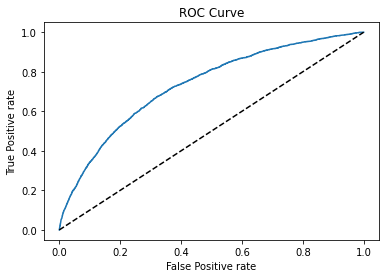

In [96]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_test_prediction_proba)
plt.plot(fpr4, tpr4)
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('ROC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()

### Make a conclusion about this model to solve you scoring model

This model is the best we have seen. It has the higher accuracy, precision, recall and ROC AUC score.  
We keep in mind theses figures :  
**AdaBoost algorithm**  
Accuracy: 91.96%.  
Precision: 47.0%.  
Recall: 1.46%.  
F1-score: 3.0%.  
ROC AUC score: 0.7321878780457098

# Use Gradient Boosting Tree algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

### Train your model on the training dataset

In [ ]:
# Model Initialization
gbt = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [ ]:
# Model Training
gbt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### Evaluate your model on the testing dataset

In [ ]:
# Results
y_train_prediction = gbt.predict(X_train)
y_test_prediction = gbt.predict(X_test)

y_train_prediction_proba = gbt.predict_proba(X_train)[:, 1]
y_test_prediction_proba = gbt.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(2)*100) + '%.')

Accuracy: 91.95%.
Precision: 38.0%.
Recall: 0.61%.
F1-score: 1.0%.


The main target indicator (Recall) is a bit small. Let's see if we can increase it with a better set of hyperparameters.

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# The tested parameters
dict_of_hyperparametrs = {'n_estimators': [5, 10, 50],
                          'max_depth' : [4, 5, 6, 7, 8],
                          'min_samples_leaf' : [1, 2, 3, 4, 5]}

In [ ]:
grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=123), dict_of_hyperparametrs, n_iter=100, verbose=1, cv=3, random_state=123, scoring='recall')

In [ ]:
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.



Fitting 3 folds for each of 75 candidates, totalling 225 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=123),
                   n_iter=100,
                   param_distributions={'max_depth': [4, 5, 6, 7, 8],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'n_estimators': [5, 10, 50]},
                   random_state=123, scoring='recall', verbose=1)

In [ ]:
# Result of the Gridsearch algorithm
grid.best_params_

{'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 50}

In [97]:
# Optimized Model Initialization
gbt_opt = GradientBoostingClassifier(max_depth=8, min_samples_leaf=5, n_estimators=50, random_state=42)

In [98]:
# Optimized Model Training
gbt_opt.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=8, min_samples_leaf=5, n_estimators=50,
                           random_state=42)

In [99]:
# Results
y_train_prediction = gbt_opt.predict(X_train)
y_test_prediction = gbt_opt.predict(X_test)

y_train_prediction_proba = gbt_opt.predict_proba(X_train)[:, 1]
y_test_prediction_proba = gbt_opt.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_test_prediction)
precision_test = precision_score(y_test, y_test_prediction)
recall_test = recall_score(y_test, y_test_prediction)
f1_test = f1_score(y_test, y_test_prediction)

print('Accuracy: ' + str(acc_test.round(4)*100) + '%.')
print('Precision: ' + str(precision_test.round(2)*100) + '%.')
print('Recall: ' + str(recall_test.round(4)*100) + '%.')
print('F1-score: ' + str(f1_test.round(2)*100) + '%.')

Accuracy: 91.92%.
Precision: 39.0%.
Recall: 1.34%.
F1-score: 3.0%.


This model has a good performances but the AdaBoost is slightly better, even on the recall, our main indicator.

### Extract the feature importance of the model

In [ ]:
feature_importance_gbt_opt = gbt_opt.feature_importances_
feature_importances_gbt_opt = pd.DataFrame({'feature': ['FLAG_DOCUMENT_3', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] ,
                                    'importance': feature_importance_gbt_opt}).sort_values(by=['importance'], ascending=False)
feature_importances_gbt_opt.head()

,feature,importance
9,EXT_SOURCE_2,0.312379
10,EXT_SOURCE_3,0.302470
8,EXT_SOURCE_1,0.133132
2,DAYS_ID_PUBLISH,0.085886
4,DAYS_LAST_PHONE_CHANGE,0.067647


There are the same than for the AdaBoost model.

### Graphical representation of the result

You can use ROC curve

In [100]:
auc_log = roc_auc_score(y_test,y_test_prediction_proba)
print('ROC AUC score:', auc_log)

ROC AUC score: 0.7328757488184678


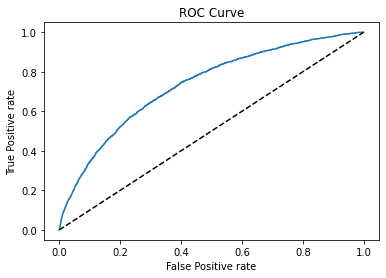

In [101]:
fpr5, tpr5, thresholds = roc_curve(y_test, y_test_prediction_proba)
plt.plot(fpr5, tpr5)
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('ROC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()

This is our best curve since the beginning.

### Make a conclusion about this model to solve you scoring model

This model is a bit under the AdaBoost model, even with a better ROC AUC, we prefer maximize the Recall and the Accuracy.  
We keep in mind theses figures :  
**Gradient Boosting Tree Algorithm**  
Accuracy: 91.92%.  
Precision: 39.0%.  
Recall: 1.34%.  
F1-score: 3.0%.  
ROC AUC score: 0.7328757488184678


# Use Support Vector Machine to train a model

Use the same structure as before

# Compare all you model to solve the scoring problem

### Metrics comparaison

In [3]:
result = {
    'Model' : ['Logistic Regression','Decision Tree','Random Forest','AdaBoost','Gradient Boosting Tree'],
    'Accuracy' : ['91.94%', '91.96%', '91.91%', '91.96%', '91.92%'],
    'Precision' : ['30.0%', '45.0%', '37.0%', '47.0%', '39.0'],
    'Recall' : ['0.32%', '0.97%', '1.13%', '1.46%', '1.34%'],
    'F1-score' : ['0.64%','1.9%', '2.0%', '3.0%', '3.0%'],
    'ROC AUC score' : [0.7293463751572016, 0.7073119821918012, 0.7017782331513471, 0.7321878780457098, 0.7328757488184678]
}

df = pd.DataFrame(result)

df

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC score
0,Logistic Regression,91.94%,30.0%,0.32%,0.64%,0.729346
1,Decision Tree,91.96%,45.0%,0.97%,1.9%,0.707312
2,Random Forest,91.91%,37.0%,1.13%,2.0%,0.701778
3,AdaBoost,91.96%,47.0%,1.46%,3.0%,0.732188
4,Gradient Boosting Tree,91.92%,39.0,1.34%,3.0%,0.732876


AdaBoost is the best model to maximize Recall, Accuracy and ROC AUC score.  
We can see that complex model are better than the basic Logistic Regression? 

### Graphical comparaison

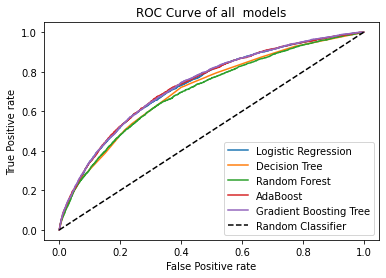

In [104]:
# Plot the curve
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot(fpr4, tpr4)
plt.plot(fpr5, tpr5)
plt.plot([0, 1], [0, 1], 'k--') 
plt.legend(['Logistic Regression','Decision Tree','Random Forest','AdaBoost','Gradient Boosting Tree', 'Random Classifier'])
plt.title('ROC Curve of all  models')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()

The curves are very close, we have slighlty improve the model.  
And all the models are better than a sample coin flip.

### Submit your result on Kaggle

In [ ]:
# Issue with my google account, I cannot submit it. 

# Make a general conclusion for this project

The main difficulty was to start, because there are a lot variables in the dataset and it was important to select the good ones.  
The other difficulty is to deal with very littles differences between the model and the optimized ones. Finally, compare to the baseline, we only gains 0.03% of accuracy...  
For me, it is because the dataset is really imbalanced, with very few 1 on the target variable.  


Mathieu MARCHAND 62677